# Investigation of Trip Data from Bay Area Bike Share Published Data

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
from scipy import stats
import scipy
import math
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import datetime

import seaborn as sns
# sns.set()
sns.set_style('whitegrid')
sns.set_context("poster")

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

font = {'size'   : 50}
matplotlib.rc('font', **font)

TITLE_FONT_SIZE = 25
LABEL_FONT_SIZE = 15
TICK_FONT_SIZE  = 10

# Load Trip Data

In [3]:
print('[%s] Loading Trip Data Data...' % datetime.datetime.now().time())

trips_df = pd.DataFrame()
trip_data_file = '../clean_data/bayareabikeshare/trip_data_extended_cleaned.csv'

# Chunk Settings
chunks = []
chunk_counter = 1
chunksize = 10000
num_chunks = math.ceil(sum(1 for row in open(trip_data_file, 'r'))/chunksize)

# import file in chunks
for chunk in pd.read_csv(trip_data_file, chunksize=chunksize, iterator=True, index_col=0, parse_dates=['start_date', 'end_date']):
    
    # append chunk to chunks list
    chunks.append(chunk)

    if chunk_counter == 1 or chunk_counter % math.ceil(num_chunks/10) == 0 or chunk_counter == num_chunks:
        print('\t\t[%s] finished chunk %s of %s' % (datetime.datetime.now().time(), chunk_counter, num_chunks))
    chunk_counter += 1

trips_df = pd.concat(chunks)
trips_df.user_type = trips_df.user_type.astype('category')

print('[%s] Complete!' % datetime.datetime.now().time())


[02:02:26.399127] Loading Trip Data Data...
		[02:02:27.365093] finished chunk 1 of 100
		[02:02:28.235812] finished chunk 10 of 100
		[02:02:29.172014] finished chunk 20 of 100
		[02:02:29.992386] finished chunk 30 of 100
		[02:02:30.805996] finished chunk 40 of 100
		[02:02:31.713587] finished chunk 50 of 100
		[02:02:32.584512] finished chunk 60 of 100
		[02:02:33.446328] finished chunk 70 of 100
		[02:02:34.252226] finished chunk 80 of 100
		[02:02:35.253960] finished chunk 90 of 100
		[02:02:36.121535] finished chunk 100 of 100
[02:02:36.785132] Complete!


In [4]:
trips_df.head(5)

,trip_id,duration,start_date,start_station_name,start_terminal,end_date,end_station_name,end_terminal,bike_id,user_type,...,end_zip,max_temp,mean_temp,min_temp,max_wind,mean_wind,max_gust,precipitation,cloud_cover,events
0,4069,174,2013-08-29 09:08:00,2nd at South Park,64,2013-08-29 09:11:00,2nd at South Park,64,288,Subscriber,...,94107,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN
1,4073,1067,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:42:00,San Francisco Caltrain 2 (330 Townsend),69,321,Subscriber,...,94107,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN
2,4074,1131,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,317,Subscriber,...,94107,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN
3,4075,1117,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,316,Subscriber,...,94107,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN
4,4076,1118,2013-08-29 09:25:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,322,Subscriber,...,94107,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN


In [5]:
trips_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 998523 entries, 0 to 998522
Data columns (total 23 columns):
trip_id               998523 non-null int64
duration              998523 non-null int64
start_date            998523 non-null datetime64[ns]
start_station_name    998523 non-null object
start_terminal        998523 non-null int64
end_date              998523 non-null datetime64[ns]
end_station_name      998523 non-null object
end_terminal          998523 non-null int64
bike_id               998523 non-null int64
user_type             998523 non-null category
user_zip              998523 non-null int64
duration_minutes      998523 non-null float64
start_zip             998523 non-null int64
end_zip               998523 non-null int64
max_temp              998458 non-null float64
mean_temp             998458 non-null float64
min_temp              998458 non-null float64
max_wind              998518 non-null float64
mean_wind             998518 non-null float64
max_gust          

## Utility Functions

In [6]:
day_labels = ['MON','TUE','WED','THU','FRI','SAT','SUN']
day_labels_full = ['MONDAY','TUESDAY','WEDNESDAY','THURSDAY','FRIDAY','SATURDAY','SUNDAY']
month_labels = ['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']

zip_lookup = {
    94107 : 'San Francisco',
    94063 : 'Redwood City',
    94301 : 'Palo Alto',
    94041 : 'Mountain View',
    95113 : 'San Jose'
}

# Goal 1 - Identify Key User Groups

- All Users
    - Customers
    - Subscribers

In [7]:
# Separate Customer Data and SUbscriber Data
customer_trips_df = trips_df[trips_df.user_type == 'Customer'].copy()
subscriber_trips_df = trips_df[trips_df.user_type == 'Subscriber'].copy()

print('Description\t\t\tTrip Count\tShare')
print('Total Trips Records\t\t%s' % len(trips_df))
print('Total Subscriber Trip Records\t%s\t\t%0.2f' % (len(subscriber_trips_df), len(subscriber_trips_df)/len(trips_df)*100.))
print('Total Customer Trip Records\t%s\t\t%0.2f' % (len(customer_trips_df), len(customer_trips_df)/len(trips_df)*100.))


Description			Trip Count	Share
Total Trips Records		998523
Total Subscriber Trip Records	879044		88.03
Total Customer Trip Records	119479		11.97


# Goal 2 - Identify Usage Patterns for User Groups

> We have two key user groups, what are the similarities and difference of their ussage?
- Subscribers
    - Hour of the Day - Two Distinct peaks, during commute hours
    - Day of the Week - Weekday Trips out number Weekend Trips nearly 5 to 1
    - Month of the Year - Rougly 35% dip in November into December, remainder of year steady
- Customers
    - Hour of the Day - Nice Even lump during daylight hours 8am-7pm
    - Day of the Week - Weekends are busiest, but not by much
    - Month of the Year - Peak in September, busiest in Summer months
    
> How do these groups compare by volume?
- Subscribers make up 88.39% of all Trips
    - 78% of all Subscriber trips are during commuting hours


## Hourly Trip Distribution by User Type

In [8]:
x_ticks = sorted(pd.unique(trips_df.start_date.dt.hour))
subscriber_y = trips_df[trips_df.user_type == 'Subscriber'].groupby(trips_df.start_date.dt.hour)['trip_id'].count()
customer_y   = trips_df[trips_df.user_type == 'Customer'].groupby(trips_df.start_date.dt.hour)['trip_id'].count()

sub_norm  = subscriber_y.to_frame().apply(lambda x: x / (np.max(x) - np.min(x)))
cust_norm =   customer_y.to_frame().apply(lambda x: x / (np.max(x) - np.min(x)))

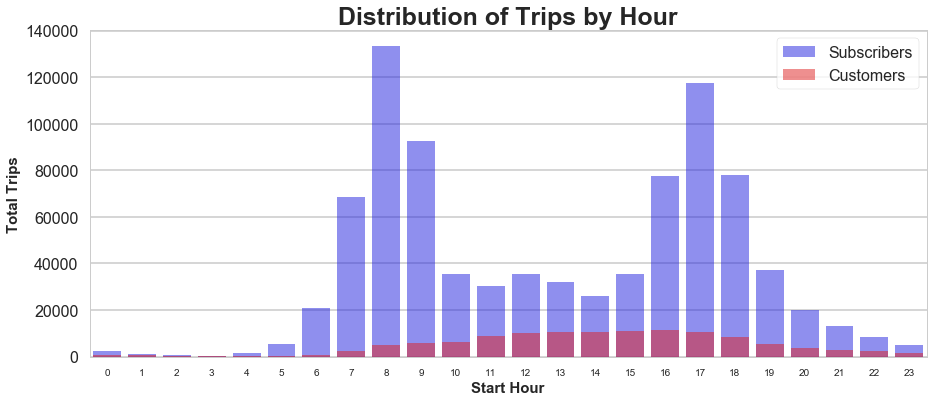

In [9]:
# Trips by Hour by Customer Type
plt.subplots(figsize=(15,6))
ax = sns.barplot(x = x_ticks , y = subscriber_y, color='b', alpha = 0.5, label='Subscribers')
sns.barplot(x = x_ticks , y = customer_y, color='r', alpha = 0.5, label='Customers', ax=ax)

ax.set_title('Distribution of Trips by Hour', size=TITLE_FONT_SIZE, weight='bold')
ax.set_xlabel('Start Hour', size=LABEL_FONT_SIZE, weight='bold')
ax.set_ylabel('Total Trips', size=LABEL_FONT_SIZE, weight='bold')
ax.set_xticklabels(x_ticks, size=TICK_FONT_SIZE)

fig = ax.get_figure()
save_file = '../charts/Investigation_01_User_Trips_Distribution.png'
fig.savefig(save_file)

plt.legend(loc=1, frameon=True)
plt.show()

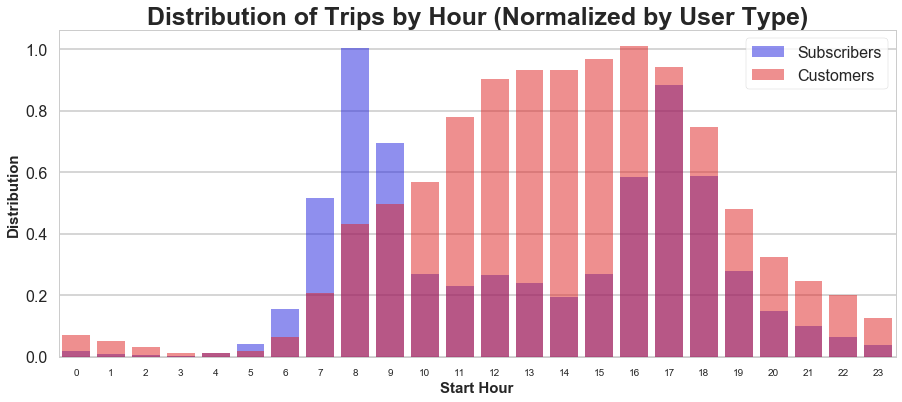

In [10]:
# Normalized Trips by Hour by Customer Type
plt.subplots(figsize=(15,6))
ax = sns.barplot(x = x_ticks , y = sub_norm['trip_id'], color='b', alpha = 0.5, label='Subscribers')
sns.barplot(x = x_ticks , y = cust_norm['trip_id'], color='r', alpha = 0.5, label='Customers', ax=ax)

ax.set_title('Distribution of Trips by Hour (Normalized by User Type)', size=TITLE_FONT_SIZE, weight='bold')
ax.set_xlabel('Start Hour', size=LABEL_FONT_SIZE, weight='bold')
ax.set_ylabel('Distribution', size=LABEL_FONT_SIZE, weight='bold')
ax.set_xticklabels(x_ticks, size=TICK_FONT_SIZE)    

fig = ax.get_figure()
save_file = '../charts/Investigation_01_User_Trips_Distribution_Normalized.png'
fig.savefig(save_file)

plt.legend(loc=1, frameon=True)
plt.show()

# Usage Trends by User Type

In [11]:
def plot_trip_distributions(df = None, user_type = 'Subscriber', color='b', h_step=10000, d_step=25000, m_step=10000):
    
    def draw_plot(user_type, x, y, title, x_label, y_label, x_tick_labels, y_step, draw_lines = []):

        plt.subplots(figsize=(15,6))
        ax = sns.barplot(x = x, 
                         y = y, 
                         color = color, 
                         alpha = 0.5, 
                         label=user_type)

        ax.set_title(title, size=TITLE_FONT_SIZE, weight='bold')
        

        ax.set_xlabel(x_label, size=LABEL_FONT_SIZE, weight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(x_tick_labels, size=TICK_FONT_SIZE)

        y_max = int(math.ceil(y.max() / y_step) * y_step) + y_step
        y_ticks = range(0, y.max()+y_step, y_step)

        ax.set_ylabel(y_label, size=LABEL_FONT_SIZE, weight='bold')
        ax.set_yticks(y_ticks)

        if len(draw_lines) > 0 and user_type == 'Subscriber':
            for xc in draw_lines:
                ax.axvline(x=xc, color='k', linestyle=':', alpha=0.5)
        else:
            for xc in draw_lines[2:]:
                ax.axvline(x=xc, color='k', linestyle=':', alpha=0.5)
            
        fig = ax.get_figure()
        save_file = '../charts/Investingation_%s' % (title.strip().replace(' - ', '_').replace(' ', '_'))
        fig.savefig(save_file)

        plt.legend(loc=1, frameon=True)
        plt.show()
     
    # Draw Trips by Hour of Day
    
    # Only Weekdays
    draw_plot(user_type=user_type,
              x = sorted(pd.unique(df.start_date.dt.hour)), 
              y = df[(df.user_type == user_type) & (df.start_date.dt.dayofweek <= 4)].groupby(df.start_date.dt.hour)['trip_id'].count(), 
              title = ' %s Daily Trips by Hour - Weekdays Only' % user_type.title(), 
              x_label = 'Hour', 
              y_label = 'Trip Count', 
              x_tick_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
                               '11', '12', '13', '14', '15', '16', '17', '18', '19', '20',
                               '21', '22', '23'],
              y_step = h_step,
              draw_lines=[6.5, 10.5, 15.5, 19.5])
    
    
    # Only Weekends
    draw_plot(user_type=user_type,
              x = sorted(pd.unique(df.start_date.dt.hour)), 
              y = df[(df.user_type == user_type) & (df.start_date.dt.dayofweek > 4)].groupby(df.start_date.dt.hour)['trip_id'].count(), 
              title = ' %s Daily Trips by Hour - Weekends Only' % user_type.title(), 
              x_label = 'Hour', 
              y_label = 'Trip Count', 
              x_tick_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
                               '11', '12', '13', '14', '15', '16', '17', '18', '19', '20',
                               '21', '22', '23'],
              y_step = 1000)
    
    # all days
    draw_plot(user_type=user_type,
              x = sorted(pd.unique(df.start_date.dt.hour)), 
              y = df[df.user_type == user_type].groupby(df.start_date.dt.hour)['trip_id'].count(), 
              title = ' %s Daily Trips by Hour' % user_type.title(), 
              x_label = 'Hour', 
              y_label = 'Trip Count', 
              x_tick_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
                               '11', '12', '13', '14', '15', '16', '17', '18', '19', '20',
                               '21', '22', '23'],
              y_step = h_step)

    
    
    # Draw Trips by Day of Week
    weekday_map= {0:'MON', 1:'TUE', 2:'WED', 3:'THU',
                  4:'FRI', 5:'SAT', 6:'SUN'}
    
    draw_plot(user_type=user_type,
              x = sorted(pd.unique(df.start_date.dt.dayofweek)), 
              y = df[df.user_type == user_type].groupby(df.start_date.dt.dayofweek)['trip_id'].count(), 
              title = ' %s Weekly Trips by Day' % user_type.title(), 
              x_label = 'Day of Week', 
              y_label = 'Trip Count', 
              x_tick_labels = [weekday_map[d] for d in sorted(pd.unique(df.start_date.dt.dayofweek))],
              y_step = d_step)

    # Draw Trips by Month of Year
    month_map = {1:'JAN', 2:'FEB', 3:'MAR', 4:'APR', 
                 5:'MAY', 6:'JUN', 7:'JUL', 8:'AUG', 
                 9:'SEP', 10:'OCT', 11:'NOV', 12:'DEC'}

    month_ticks = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    draw_plot(user_type=user_type,
              x = month_ticks,
              y = df[df.user_type == user_type].groupby(df.start_date.dt.month)['trip_id'].count(), 
              title = ' %s Monthly Trips by Year' % user_type.title(), 
              x_label = 'Month', 
              y_label = 'Trip Count', 
              x_tick_labels = [month_map[d] for d in sorted(pd.unique(df.start_date.dt.month))],
              y_step = m_step)

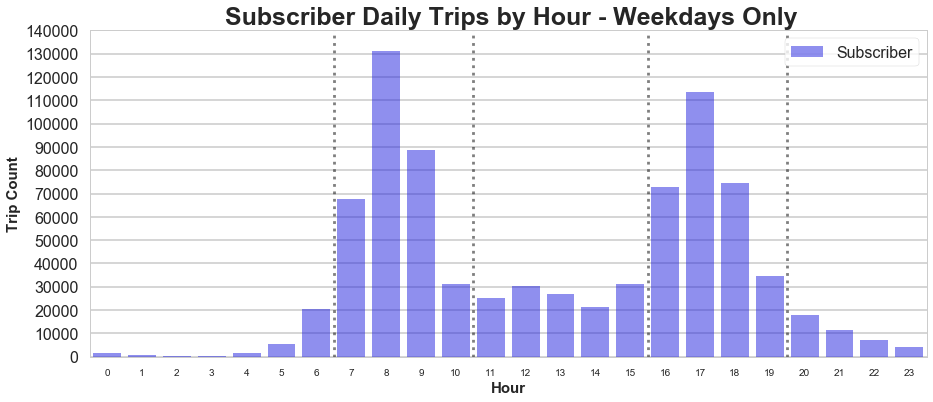

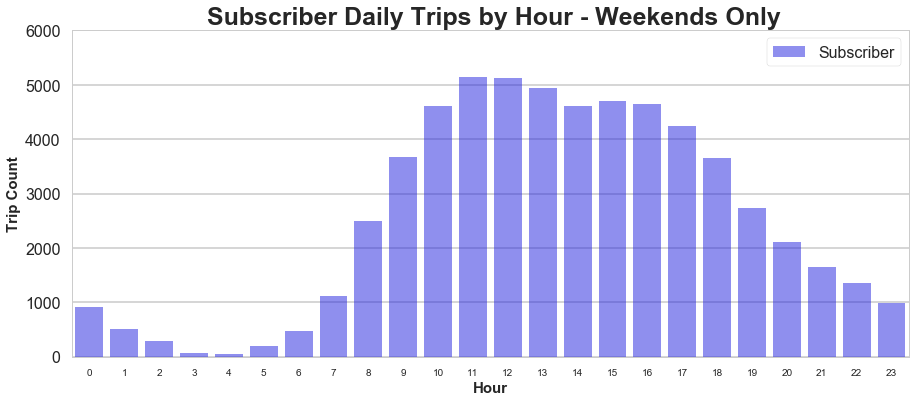

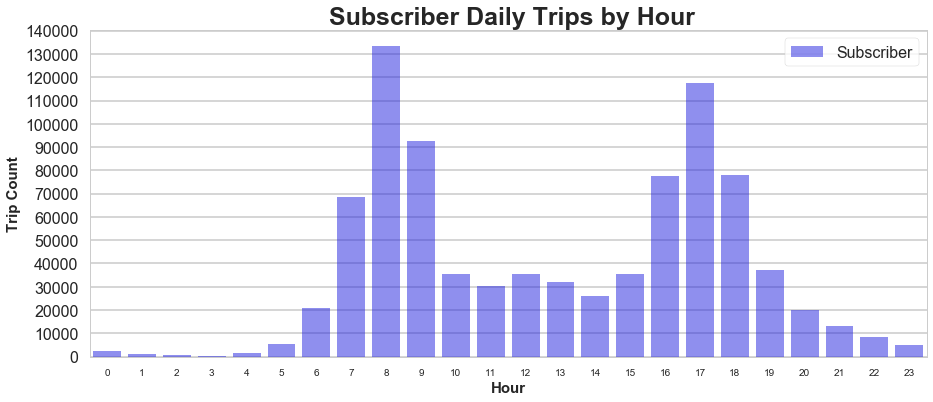

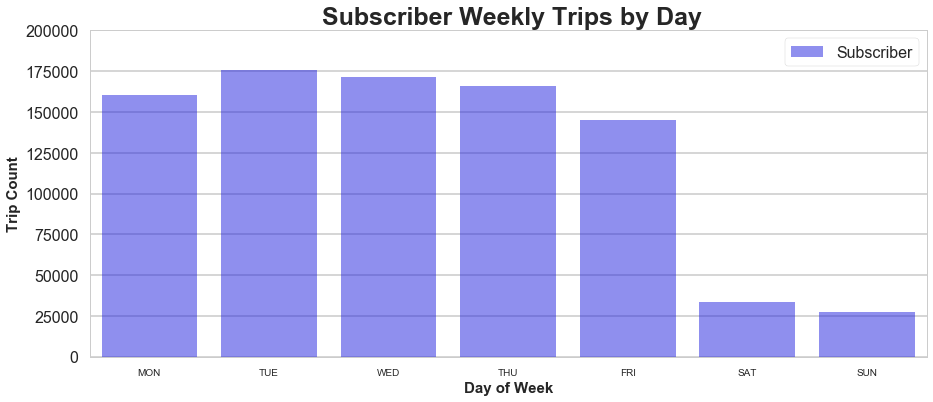

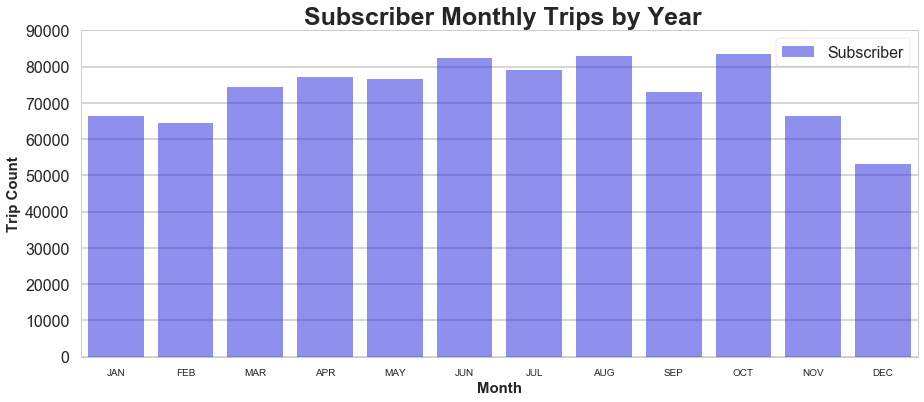

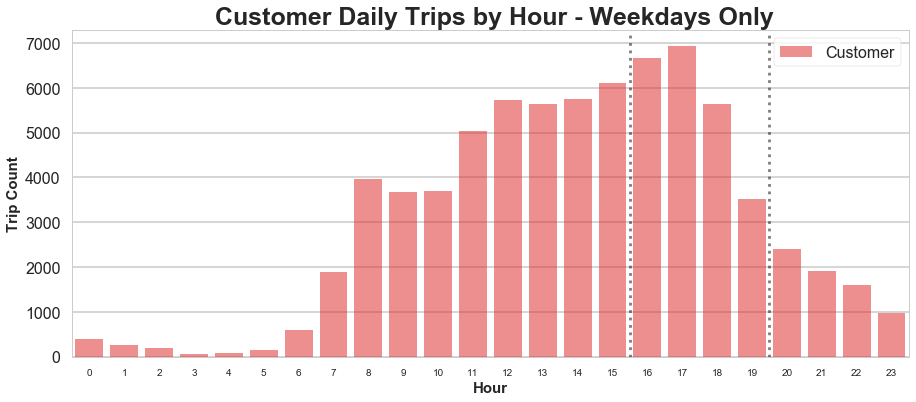

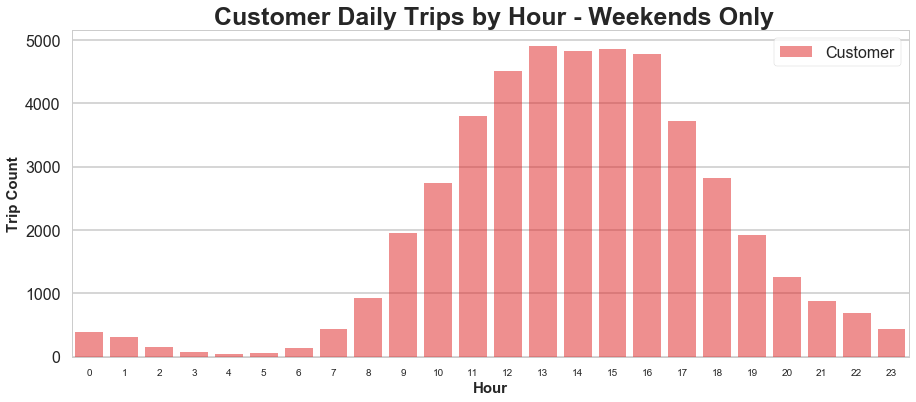

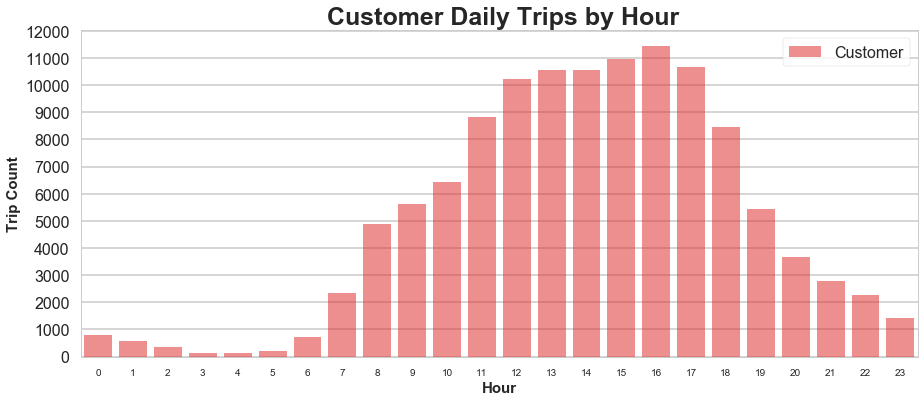

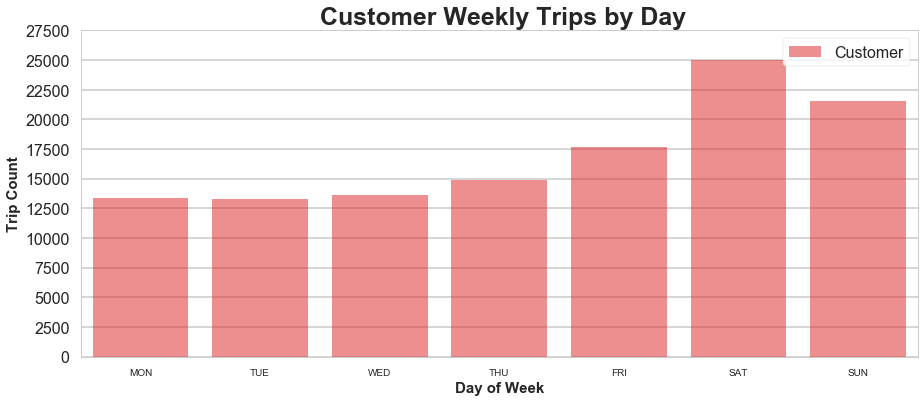

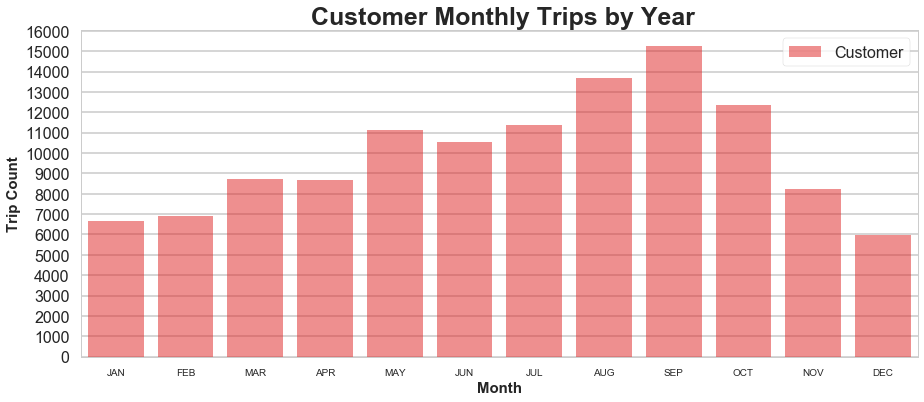

In [12]:
plot_trip_distributions(df = trips_df, user_type = 'Subscriber', color='b', h_step=10000, d_step=25000, m_step=10000)
plot_trip_distributions(df = trips_df, user_type = 'Customer',   color='r', h_step=1000,  d_step=2500,  m_step=1000)

# Goal 3 - Identify Trends in Service Areas

<p> The Bay Area Bike Share Program serves 5 Metro Areas </p>

<ul>
    <li>San Francisco
    <li>San Jose
    <li>Mountain View
    <li>Palo Alto
    <li>Redwood City
</ul>


## Load Station Data
<p>Not All Stations have been open the same dates, we will need to adjust usaeg numbers accordingly to properly copare popularity<p>

In [13]:
station_df = pd.DataFrame()

station_df = pd.read_csv('../clean_data/bayareabikeshare/station_data_cleaned.csv', index_col=0, parse_dates=['last_service_date', 'first_service_date'])
station_df.head()

,station_id,name,lat,long,dock_count,landmark,first_service_date,last_service_date,zip_code,days_in_service
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,2013-08-29,2016-08-31,95113,1098
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,2013-08-29,2016-08-31,95113,1098
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,2013-08-29,2016-08-31,95113,1098
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,2013-08-29,2016-08-31,95113,1098
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,2013-08-29,2016-08-31,95113,1098


In [14]:
# calculate weekdays and weekend days in service

station_simple_df = station_df.copy()

station_simple_df['weekday_days_in_service'] = np.nan
station_simple_df['weekend_days_in_service'] = np.nan

for i in station_simple_df.index:
    s = str(station_simple_df.iloc[i,:]['first_service_date']).split(' ')[0]
    e = str(station_simple_df.iloc[i,:]['last_service_date']).split(' ')[0]
    
    days = pd.date_range(s, e, freq='D')
    weekdays = days[days.dayofweek < 5].shape[0]
    weekends = days[days.dayofweek >= 5].shape[0] - 1
    
    station_simple_df.iloc[i,10] = weekdays
    station_simple_df.iloc[i,11] = weekends
    
# merge down duplicated station_ids, take sum of service days columns
station_simple_df = station_simple_df.groupby('station_id').sum()
station_simple_df.drop(['lat', 'long', 'dock_count'], axis=1, inplace=True)

# adjust zipcodes that may have been duplicates on sum transformation
station_simple_df['zip_code'] = station_simple_df['zip_code'].apply(lambda x: x/2 if x > 99999 else x).astype('int')

station_simple_df.head()

,zip_code,days_in_service,weekday_days_in_service,weekend_days_in_service
station_id,,,,
2,95113,1098,785.0,313.0
3,95113,1098,785.0,313.0
4,95113,1098,785.0,313.0
5,95113,1098,785.0,313.0
6,95113,1098,785.0,313.0


# Average Trips from Each Station

In [15]:
# create a dataframe of trips/day of service for customer types and usage patterns
def make_station_popularity_frame(df=None, service_days='days_in_service'):
    
    subs_df = df[df.user_type == 'Subscriber'].copy()
    cust_df = df[df.user_type == 'Customer'].copy()

    pop_df = pd.DataFrame()

    # count of trips startng at each terminal, for user type
    pop_df['subscriber_start'] = subs_df.groupby('start_terminal')['start_terminal'].count()
    pop_df['customer_start'] = cust_df.groupby('start_terminal')['start_terminal'].count()

    # count of trips ending at each terminal, for user type
    pop_df['subscriber_end'] = subs_df.groupby('end_terminal')['end_terminal'].count()
    pop_df['customer_end'] = cust_df.groupby('end_terminal')['end_terminal'].count()
        
    pop_df[service_days] = station_simple_df[service_days]
    
    # append daily average columns    
    pop_df['subscriber_start_per_day'] = pop_df['subscriber_start'] / pop_df[service_days]
    pop_df['customer_start_per_day'] = pop_df['customer_start'] / pop_df[service_days]
    pop_df['subscriber_end_per_day'] = pop_df['subscriber_end'] / pop_df[service_days]
    pop_df['customer_end_per_day'] = pop_df['customer_end'] / pop_df[service_days]

    return pop_df

In [16]:
station_pop_all = make_station_popularity_frame(df=trips_df, service_days='days_in_service')
station_pop_weekday = make_station_popularity_frame(df=trips_df[trips_df.start_date.dt.dayofweek < 5], service_days='weekday_days_in_service')
station_pop_weekend = make_station_popularity_frame(df=trips_df[trips_df.start_date.dt.dayofweek >= 5], service_days='weekend_days_in_service')

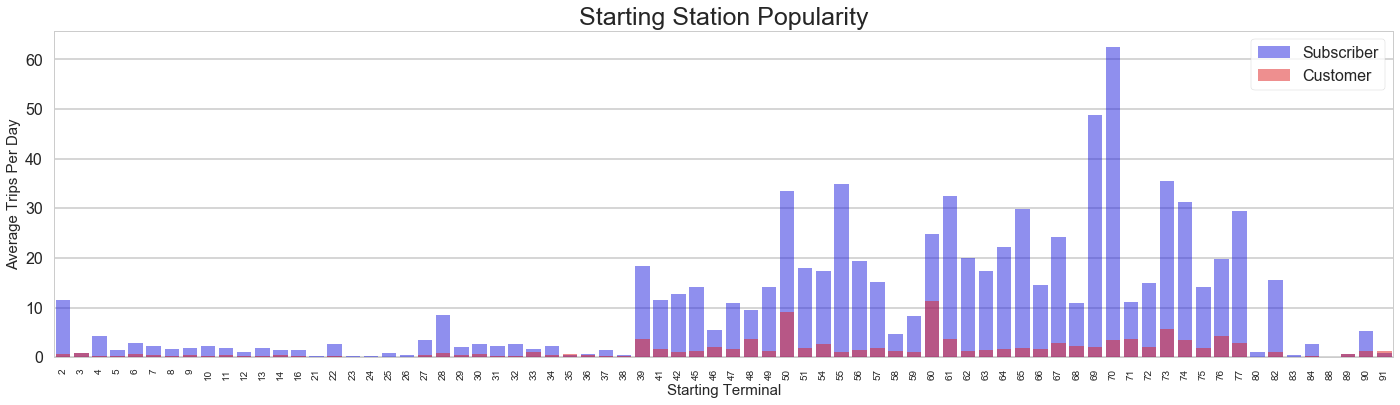

In [17]:
plt.subplots(figsize=(24,6))
subscriber_y = station_pop_all['subscriber_start_per_day']
customer_y = station_pop_all['customer_start_per_day']
ax = sns.barplot(x=station_pop_all.index, y=subscriber_y, color='b', alpha=0.5, label='Subscriber')
sns.barplot(x=station_pop_all.index, y=customer_y, color='r', alpha=0.5, ax=ax, label='Customer')
ax.set_title('Starting Station Popularity', size=TITLE_FONT_SIZE)
ax.set_xlabel('Starting Terminal', size=LABEL_FONT_SIZE)
ax.set_xticklabels(labels=station_pop_all.index, size=TICK_FONT_SIZE, rotation=90)
ax.set_ylabel('Average Trips Per Day', size=LABEL_FONT_SIZE)
ax.legend(loc=1, frameon=True)

save_file = '../charts/Investingation_Starting_Station_Popularity.png'
plt.savefig(save_file)

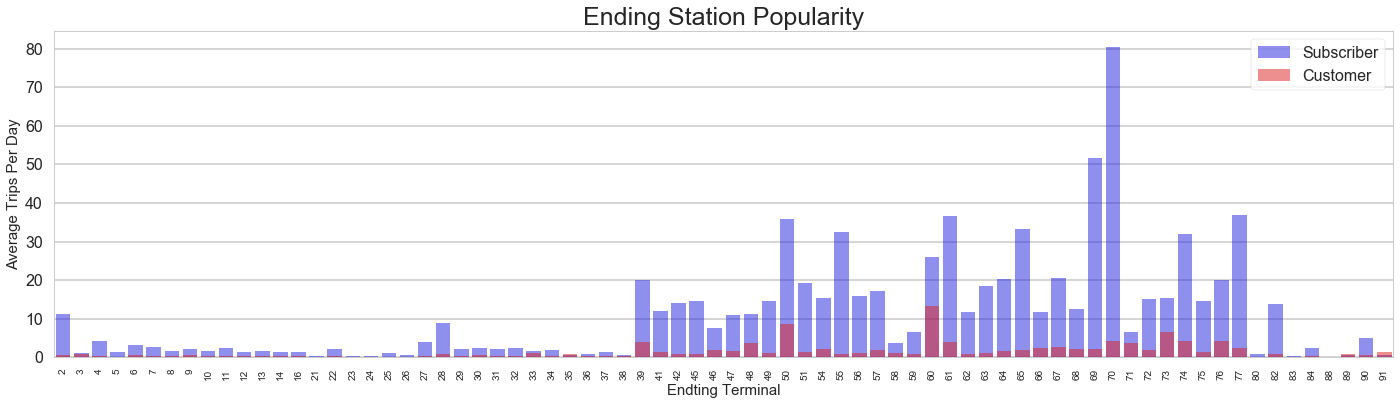

In [18]:
plt.subplots(figsize=(24,6))
subscriber_y = station_pop_all['subscriber_end_per_day']
customer_y = station_pop_all['customer_end_per_day']
ax = sns.barplot(x=station_pop_all.index, y=subscriber_y, color='b', alpha=0.5, label='Subscriber')
sns.barplot(x=station_pop_all.index, y=customer_y, color='r', alpha=0.5, ax=ax, label='Customer')
ax.set_title('Ending Station Popularity', size=TITLE_FONT_SIZE)
ax.set_xlabel('Endting Terminal', size=LABEL_FONT_SIZE)
ax.set_xticklabels(labels=station_pop_all.index, size=TICK_FONT_SIZE, rotation=90)
ax.set_ylabel('Average Trips Per Day', size=LABEL_FONT_SIZE)
ax.legend(loc=1, frameon=True)

save_file = '../charts/Investingation_Ending_Station_Popularity.png'
plt.savefig(save_file)

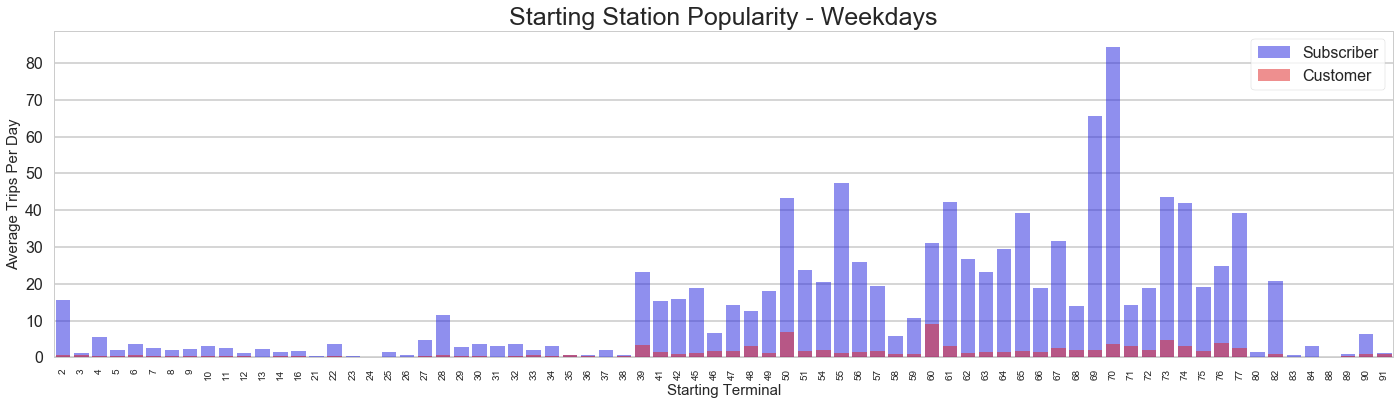

In [19]:
plt.subplots(figsize=(24,6))
subscriber_y = station_pop_weekday['subscriber_start_per_day']
customer_y = station_pop_weekday['customer_start_per_day']
ax = sns.barplot(x=station_pop_weekday.index, y=subscriber_y, color='b', alpha=0.5, label='Subscriber')
sns.barplot(x=station_pop_weekday.index, y=customer_y, color='r', alpha=0.5, ax=ax, label='Customer')
ax.set_title('Starting Station Popularity - Weekdays', size=TITLE_FONT_SIZE)
ax.set_xlabel('Starting Terminal', size=LABEL_FONT_SIZE)
ax.set_xticklabels(labels=station_pop_weekday.index, size=TICK_FONT_SIZE, rotation=90)
ax.set_ylabel('Average Trips Per Day', size=LABEL_FONT_SIZE)
ax.legend(loc=1, frameon=True)

save_file = '../charts/Investingation_Starting_Station_Popularity_Weekdays.png'
plt.savefig(save_file)

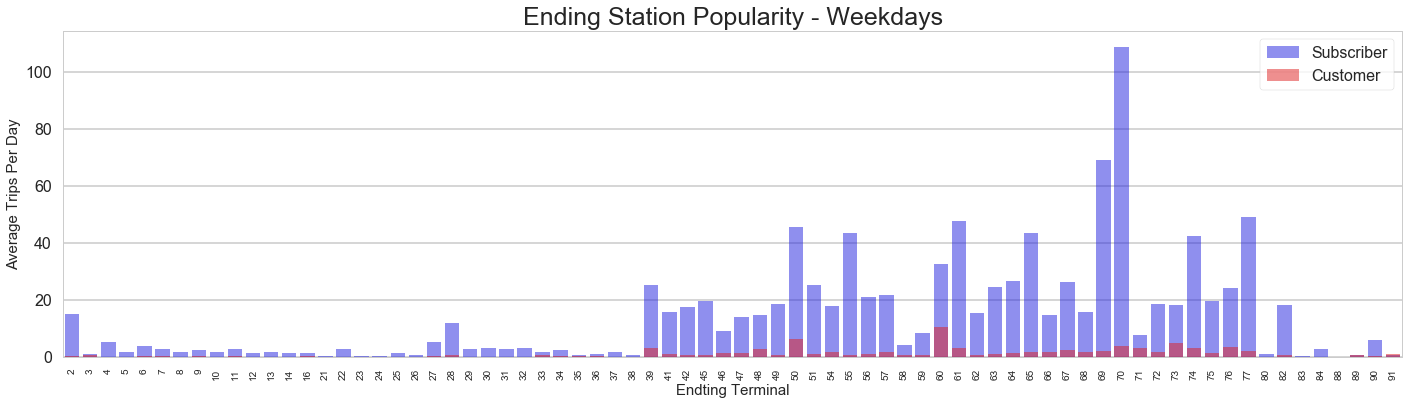

In [20]:
plt.subplots(figsize=(24,6))
subscriber_y = station_pop_weekday['subscriber_end_per_day']
customer_y = station_pop_weekday['customer_end_per_day']
ax = sns.barplot(x=station_pop_weekday.index, y=subscriber_y, color='b', alpha=0.5, label='Subscriber')
sns.barplot(x=station_pop_weekday.index, y=customer_y, color='r', alpha=0.5, ax=ax, label='Customer')
ax.set_title('Ending Station Popularity - Weekdays', size=TITLE_FONT_SIZE)
ax.set_xlabel('Endting Terminal', size=LABEL_FONT_SIZE)
ax.set_xticklabels(labels=station_pop_weekday.index, size=TICK_FONT_SIZE, rotation=90)
ax.set_ylabel('Average Trips Per Day', size=LABEL_FONT_SIZE)
ax.legend(loc=1, frameon=True)

save_file = '../charts/Investingation_Ending_Station_Popularity_Weekdays.png'
plt.savefig(save_file)

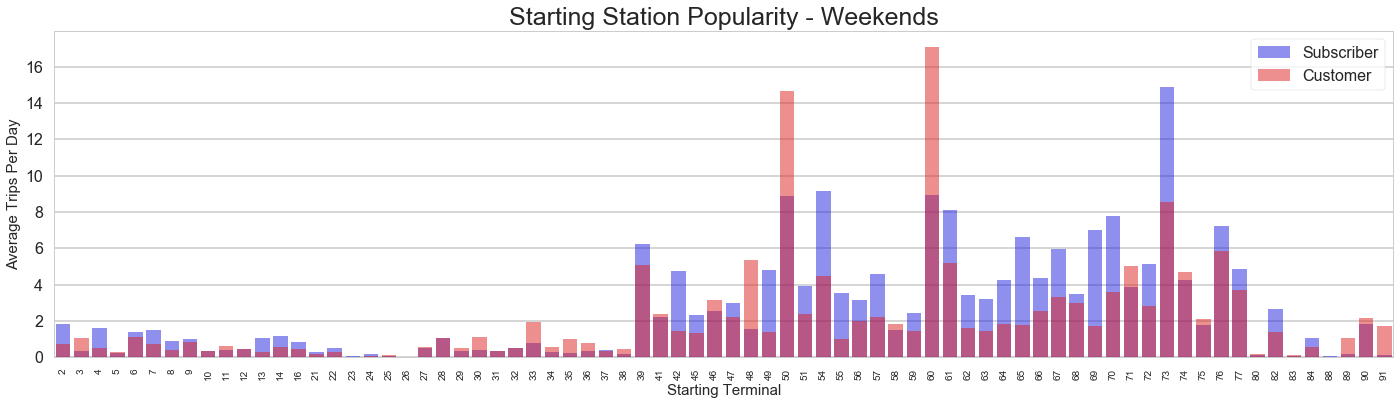

In [21]:
plt.subplots(figsize=(24,6))
subscriber_y = station_pop_weekend['subscriber_start_per_day']
customer_y = station_pop_weekend['customer_start_per_day']
ax = sns.barplot(x=station_pop_weekend.index, y=subscriber_y, color='b', alpha=0.5, label='Subscriber')
sns.barplot(x=station_pop_weekend.index, y=customer_y, color='r', alpha=0.5, ax=ax, label='Customer')
ax.set_title('Starting Station Popularity - Weekends', size=TITLE_FONT_SIZE)
ax.set_xlabel('Starting Terminal', size=LABEL_FONT_SIZE)
ax.set_xticklabels(labels=station_pop_weekend.index, size=TICK_FONT_SIZE, rotation=90)
ax.set_ylabel('Average Trips Per Day', size=LABEL_FONT_SIZE)
ax.legend(loc=1, frameon=True)

save_file = '../charts/Investingation_Starting_Station_Popularity_Weekends.png'
plt.savefig(save_file)

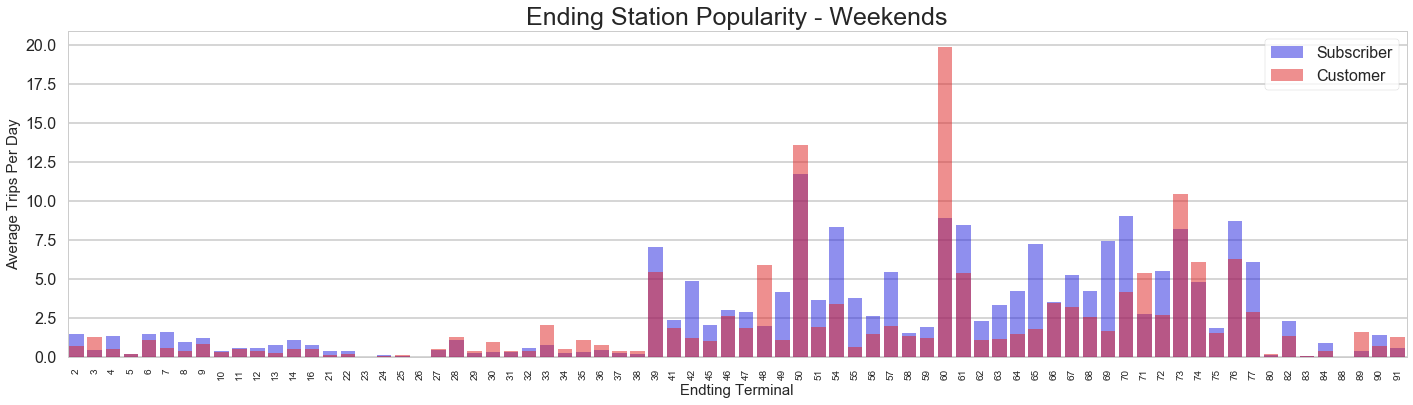

In [22]:
plt.subplots(figsize=(24,6))
subscriber_y = station_pop_weekend['subscriber_end_per_day']
customer_y = station_pop_weekend['customer_end_per_day']
ax = sns.barplot(x=station_pop_weekend.index, y=subscriber_y, color='b', alpha=0.5, label='Subscriber')
sns.barplot(x=station_pop_weekend.index, y=customer_y, color='r', alpha=0.5, ax=ax, label='Customer')
ax.set_title('Ending Station Popularity - Weekends', size=TITLE_FONT_SIZE)
ax.set_xlabel('Endting Terminal', size=LABEL_FONT_SIZE)
ax.set_xticklabels(labels=station_pop_weekend.index, size=TICK_FONT_SIZE, rotation=90)
ax.set_ylabel('Average Trips Per Day', size=LABEL_FONT_SIZE)
ax.legend(loc=1, frameon=True)

save_file = '../charts/Investingation_Ending_Station_Popularity_Weekends.png'
plt.savefig(save_file)

# Subscriber Terminal Usage

In [23]:
station_simple_df.head()

,zip_code,days_in_service,weekday_days_in_service,weekend_days_in_service
station_id,,,,
2,95113,1098,785.0,313.0
3,95113,1098,785.0,313.0
4,95113,1098,785.0,313.0
5,95113,1098,785.0,313.0
6,95113,1098,785.0,313.0


In [24]:
def make_grids(df, zip_code=-1, station_by='both'):
    '''create grids for heatmaps, outputs 5 grids:
        total_trips_grid
        normalized_total_trips_grid
        daily_mean_trips_grid   -> this is the total number of trips divided by the all days in service for given station
        weekday_mean_trips_grid -> this is the total number of trips divided by the weekday days in service for given station
        weekend_mean_trips_grid -> this is the total number of trips divided by the weekend days in service for given station
        weekend_diff_grid       -> weekday_mean_trips_grid - weekend_mean_trips_grid
        '''
    # if a single zipcode is specified, only plot data for that zipcode
    if zip_code < 5:
        data = df.copy()
    
    # else plot all terminals
    else:
        data = df[df.start_zip == zip_code].copy()
    
    
    weekend_grid = data[data.start_date.dt.dayofweek < 5].groupby(['start_terminal', 'end_terminal'])['bike_id'].count().unstack()
    weekday_grid = data[data.start_date.dt.dayofweek >= 5].groupby(['start_terminal', 'end_terminal'])['bike_id'].count().unstack()

    # plotting station utilization by start terminal only, end terminal only, or the sum of both terminals
    # creates the heatmap grid bu getting a count of trips to each terminal and unstacking the dataframe
    if station_by == 'start':
        grid_set = data.groupby(['start_terminal', 'end_terminal'])['bike_id'].count().unstack()

    elif station_by == 'end':
        grid_set = data.groupby(['end_terminal', 'start_terminal'])['bike_id'].count().unstack()

    elif station_by == 'both':
        grid_set_A = data.groupby(['end_terminal', 'start_terminal'])['bike_id'].count().unstack()
        grid_set_B = data.groupby(['start_terminal', 'end_terminal'])['bike_id'].count().unstack()
        
        grid_set = grid_set_A + grid_set_B
    
    # normalize the grid
    norm_grid     = grid_set/grid_set.max()
        
    # if mapping all stations
    if zip_code < 5:
        # the popularity grid is scaled to mean number of trips per day by dividing the total number of trips by the days the station has been active
        pop_grid = grid_set / station_simple_df['days_in_service']
        pop_grid_weekdays = weekend_grid / station_simple_df['weekday_days_in_service']
        pop_grid_weekends = weekday_grid / station_simple_df['weekend_days_in_service']
    # if mapping only zip code's stations
    else:
        pop_grid = grid_set / station_simple_df[station_simple_df.zip_code == zip_code]['days_in_service']
        pop_grid_weekdays = weekend_grid / station_simple_df[station_simple_df.zip_code == zip_code]['weekday_days_in_service']
        pop_grid_weekends = weekday_grid / station_simple_df[station_simple_df.zip_code == zip_code]['weekend_days_in_service']
    
    # revese grid rows for better visualizations
    grid_set = grid_set.reindex(index=grid_set.index[::-1])
    norm_grid = norm_grid.reindex(index=norm_grid.index[::-1])
    pop_grid = pop_grid.reindex(index=pop_grid.index[::-1])
    pop_grid_weekdays = pop_grid_weekdays.reindex(index=pop_grid_weekdays.index[::-1])
    pop_grid_weekends = pop_grid_weekends.reindex(index=pop_grid_weekends.index[::-1])
    
    weekend_diff_grid = pop_grid_weekdays - pop_grid_weekends
    
    # drop nan rows and columns from pop_grid
    pop_grid.dropna(axis=0, how='all', inplace=True)
    pop_grid.dropna(axis=1, how='all', inplace=True)
    weekend_diff_grid.dropna(axis=1, how='all', inplace=True)
    
    pop_grid_weekdays.dropna(axis=0, how='all', inplace=True)
    pop_grid_weekdays.dropna(axis=1, how='all', inplace=True)
    weekend_diff_grid.dropna(axis=1, how='all', inplace=True)
    
    pop_grid_weekends.dropna(axis=0, how='all', inplace=True)
    pop_grid_weekends.dropna(axis=1, how='all', inplace=True)
    weekend_diff_grid.dropna(axis=1, how='all', inplace=True)
    
    return [grid_set, norm_grid, pop_grid, pop_grid_weekdays, pop_grid_weekends, weekend_diff_grid]

In [80]:
def plot_grid(grid=None, zip_code=-1, user_type='Subscriber', cmap=None, station_by='both', title_suffix='', annotate=False):
    
    # make all plots the same dimensions, this is scaled to 1.5x width to accoutn for color bar
    plot_size=math.ceil(grid.shape[0]/3)
    if plot_size < 10:
        plot_size = 10

    if grid.shape[0] > 15:
        annotate = False
    
    # adjust width for color bar
    fig = plt.subplots(figsize=(plot_size*1.5, plot_size))
    
    mask = grid.isnull()
    
    # create heatmap for grid
    if annotate:
        try:
            ax = sns.heatmap(grid, linewidths=.5, square=True, cbar=False, cmap=cmap,
                         vmin=0, vmax=grid.max().max(), 
                         mask=mask, annot=True, fmt='d', annot_kws={"size":TICK_FONT_SIZE })
        except:
            ax = sns.heatmap(grid, linewidths=.5, square=True, cbar=False, cmap=cmap,
                         vmin=0, vmax=grid.max().max(), 
                         mask=mask, annot=True, fmt='0.3f', annot_kws={"size":TICK_FONT_SIZE })
    else:
        ax = sns.heatmap(grid, linewidths=.5, square=True, cbar=False, cmap=cmap,
                         vmin=0, vmax=grid.max().max())

    sns.despine()
    
    # Make Title String
    if zip_code < 5:
        title = '%s - Terminal Usage by %s' % (user_type, title_suffix.title())
    else:
        title = '%s - %s Terminal Usage by %s' % (user_type, zip_lookup[zip_code], title_suffix.title())
        
    if station_by != 'both':
        station_by = '%s Terminal' % station_by
        station_by = station_by.title()
        title = title.replace('Terminal', station_by)
    
    # strip white space from title
    title = title.strip()
    
    ax.set_title(title, size=TITLE_FONT_SIZE, weight='bold')
    
    ax.set_xlabel('End Terminal', size=LABEL_FONT_SIZE, weight='bold')
    ax.set_xticklabels(grid.columns, size=TICK_FONT_SIZE, rotation=90)

    ax.set_ylabel('Start Terminal', size=LABEL_FONT_SIZE, weight='bold')
    ax.set_yticklabels(grid.index, size=TICK_FONT_SIZE, rotation=0)    
        
    # write plot to file
    file_name = '../charts/heatmaps/Investigation_' + title.replace(' ', '_').replace('_-_', '_') + '_heatmap.png'
    
    if annotate:
        file_name = file_name.replace('.png', '_annotated.png')
    fig = ax.get_figure()
    fig.savefig(file_name)
    plt.show()


In [78]:
def plot_trip_heatmap(df, zip_code=-1, user_type='Subscriber', station_by='both', title_suffix='', annotate=False):
    
    # chose color pallet based on user_type
    if user_type == 'Customer':
        cmap = sns.color_palette("OrRd", 20)
    elif user_type == 'Subscriber':
        cmap = sns.color_palette("PuBu", 20)
    else:
        cmap = sns.color_palette("YlGn", 20)
        
    # make various grids from data frame
    trips_grid, trips_norm_grid, trips_pop_grid, trips_pop_grid_weekdays, trips_pop_grid_weekends, weekend_diff_grid = make_grids(df=df, zip_code=zip_code, station_by=station_by)
    
    # plot those grids!
    plot_grid(grid=trips_grid, zip_code=zip_code, user_type=user_type, cmap=cmap, station_by=station_by, title_suffix='Trips Count', annotate=annotate)
    plot_grid(grid=trips_norm_grid, zip_code=zip_code, user_type=user_type, cmap=cmap, station_by=station_by, title_suffix='Trips Count Normalized', annotate=annotate)
    plot_grid(grid=trips_pop_grid, zip_code=zip_code, user_type=user_type, cmap=cmap, station_by=station_by, title_suffix='Daily Mean Trips Count', annotate=annotate)
    plot_grid(grid=trips_pop_grid_weekdays, zip_code=zip_code, user_type=user_type, cmap=cmap, station_by=station_by, title_suffix='Weekday Mean Trips Count', annotate=annotate)
    plot_grid(grid=trips_pop_grid_weekends, zip_code=zip_code, user_type=user_type, cmap=cmap, station_by=station_by, title_suffix='Weekend Mean Trips Count', annotate=annotate)
    plot_grid(grid=weekend_diff_grid, zip_code=zip_code, user_type=user_type, cmap=cmap, station_by=station_by, title_suffix='Weekdays vs Weekend Mean Trips Count', annotate=annotate)

In [79]:
def heatmap_usertype_trips(df, user_type='Subscriber', by_zip=False, station_by='both', annotate=False):
    ''' Selects only user_type trips from a data frame and passes it on to generate a station utilization heatmap'''
    terminal_usage = df[df.user_type == user_type].copy()
        
    # select only trips that start and end in same zip code
    regonalized_terminal_usage = terminal_usage[terminal_usage.start_zip == terminal_usage.end_zip].copy()
    
    if by_zip:
        for zip_code in sorted(pd.unique(regonalized_terminal_usage.start_zip)):
            plot_trip_heatmap(regonalized_terminal_usage, zip_code=zip_code, user_type=user_type, station_by=station_by, annotate=annotate)
    else:
        plot_trip_heatmap(regonalized_terminal_usage, zip_code=-1, user_type=user_type, station_by=station_by, annotate=annotate)
    
    


## Print Heatmaps for Each Region

In [ ]:
heatmap_usertype_trips(trips_df, user_type='Subscriber', station_by='start', by_zip=True, annotate=False)
heatmap_usertype_trips(trips_df, user_type='Subscriber', station_by='end', by_zip=True, annotate=False)
heatmap_usertype_trips(trips_df, user_type='Subscriber', station_by='both', by_zip=True, annotate=False)

heatmap_usertype_trips(trips_df, user_type='Subscriber', station_by='start', by_zip=False, annotate=False)
heatmap_usertype_trips(trips_df, user_type='Subscriber', station_by='end', by_zip=False, annotate=False)
heatmap_usertype_trips(trips_df, user_type='Subscriber', station_by='both', by_zip=False, annotate=False)

heatmap_usertype_trips(trips_df, user_type='Subscriber', station_by='start', by_zip=True, annotate=True)
heatmap_usertype_trips(trips_df, user_type='Subscriber', station_by='end', by_zip=True, annotate=True)
heatmap_usertype_trips(trips_df, user_type='Subscriber', station_by='both', by_zip=True, annotate=True)

heatmap_usertype_trips(trips_df, user_type='Subscriber', station_by='start', by_zip=False, annotate=True)
heatmap_usertype_trips(trips_df, user_type='Subscriber', station_by='end', by_zip=False, annotate=True)
heatmap_usertype_trips(trips_df, user_type='Subscriber', station_by='both', by_zip=False, annotate=True)

In [ ]:
heatmap_usertype_trips(trips_df, user_type='Customer', station_by='start', by_zip=True, annotate=False)
heatmap_usertype_trips(trips_df, user_type='Customer', station_by='end', by_zip=True, annotate=False)
heatmap_usertype_trips(trips_df, user_type='Customer', station_by='both', by_zip=True, annotate=False)

heatmap_usertype_trips(trips_df, user_type='Customer', station_by='start', by_zip=False, annotate=False)
heatmap_usertype_trips(trips_df, user_type='Customer', station_by='end', by_zip=False, annotate=False)
heatmap_usertype_trips(trips_df, user_type='Customer', station_by='both', by_zip=False, annotate=False)

heatmap_usertype_trips(trips_df, user_type='Customer', station_by='start', by_zip=True, annotate=True)
heatmap_usertype_trips(trips_df, user_type='Customer', station_by='end', by_zip=True, annotate=True)
heatmap_usertype_trips(trips_df, user_type='Customer', station_by='both', by_zip=True, annotate=True)

heatmap_usertype_trips(trips_df, user_type='Customer', station_by='start', by_zip=False, annotate=True)
heatmap_usertype_trips(trips_df, user_type='Customer', station_by='end', by_zip=False, annotate=True)
heatmap_usertype_trips(trips_df, user_type='Customer', station_by='both', by_zip=False, annotate=True)